In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from imblearn import under_sampling, over_sampling
from sklearn.model_selection import train_test_split

In [3]:
#Data test
df = pd.read_csv('Data/Datapre.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12205 entries, 0 to 12204
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Month                           12205 non-null  int64  
 1   OperatingSystems                12205 non-null  int64  
 2   Browser                         12205 non-null  int64  
 3   Region                          12205 non-null  int64  
 4   TrafficType                     12205 non-null  int64  
 5   VisitorType                     12205 non-null  object 
 6   Weekend                         12205 non-null  int64  
 7   Revenue                         12205 non-null  bool   
 8   yj_Administrative               12205 non-null  float64
 9   yj_Administrative_Duration      12205 non-null  float64
 10  yj_Informational                12205 non-null  float64
 11  yj_Informational_Duration       12205 non-null  float64
 12  yj_ProductRelated               

In [4]:
df.sample(5)

,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,yj_Administrative,yj_Administrative_Duration,...,yj_ExitRates,yj_PageValues,yj_SpecialDay,visitor_type_Other,visitor_type_Returning_Visitor,totalPage_visit,total_duration,adm_rasio,info_rasio,product_rasio
906,3,1,2,3,10,Returning_Visitor,0,False,1.028024,1.154481,...,-0.391563,-0.532801,-0.337630,0,1,3.097125,3.631398,1.123010,1.043832,3.780305
11061,12,2,2,2,1,Returning_Visitor,0,False,-0.998474,-1.005468,...,1.232706,-0.532801,-0.337630,0,1,-1.053193,-1.175926,1.007005,0.944540,0.691363
2835,5,2,2,2,2,Returning_Visitor,0,False,-0.998474,-1.005468,...,0.450497,-0.532801,2.972487,0,1,-1.988715,-2.255014,1.007005,0.944540,1.618276
8206,12,2,2,1,2,Returning_Visitor,0,False,-0.998474,-1.005468,...,1.610382,-0.532801,-0.337630,0,1,-1.625719,-1.250725,1.007005,0.984442,0.840192
3099,5,1,1,3,2,Returning_Visitor,0,False,0.550281,0.446816,...,1.302618,-0.532801,2.972487,0,1,0.224657,-0.137696,0.811978,0.944540,-0.452577


## A. Split Data Train & Test 

In [5]:
#X = df[[col for col in df.columns if col not in ['VisitorType','Revenue','yj_ExitRates']]]
X = df[[col for col in df.columns if col not in ['VisitorType','Revenue','yj_ExitRates','totalPage_visit','total_duration','adm_rasio','info_rasio','product_rasio']]]
y = df['Revenue']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Metrics Model

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

    score = cross_validate(model, X, y, cv=5, scoring='roc_auc', return_train_score=True)
    print('roc_auc (crossval train): '+ str(score['train_score'].mean()))
    print('roc_auc (crossval test): '+ str(score['test_score'].mean()))
    

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(penalty='l2', C=c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('C')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter C - Logistic Regression')
    plt.legend()
    plt.show()

## Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression # import logistic regression dari sklearn
logreg = LogisticRegression() # inisiasi object dengan nama logreg
logreg.fit(X_train, y_train) # fit model regression dari data train
eval_classification(logreg)

Accuracy (Test Set): 0.88
Precision (Test Set): 0.66
Recall (Test Set): 0.59
F1-Score (Test Set): 0.62
roc_auc (test-proba): 0.91
roc_auc (train-proba): 0.90
roc_auc (crossval train): 0.9028102780148334
roc_auc (crossval test): 0.881729462893464


In [10]:
X.columns

Index(['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'Weekend', 'yj_Administrative', 'yj_Administrative_Duration',
       'yj_Informational', 'yj_Informational_Duration', 'yj_ProductRelated',
       'yj_ProductRelated_Duration', 'yj_BounceRates', 'yj_PageValues',
       'yj_SpecialDay', 'visitor_type_Other',
       'visitor_type_Returning_Visitor'],
      dtype='object')

In [11]:
logreg.coef_

array([[ 0.10906931, -0.04685923, -0.00430406, -0.0222549 , -0.0229776 ,
         0.09935259, -0.16870495, -0.04884825,  0.25189254, -0.25444101,
        -0.01145592,  0.10222193, -0.45122176,  1.50475341, -0.12508458,
        -0.69040274, -0.85145036]])

In [21]:
from sklearn.model_selection import RandomizedSearchCV

penalty = ['l1', 'l2']
C = [float(x) for x in np.linspace(0.00001, 0.0005, 100)]
hyperparameters = dict(penalty=penalty, C=C)

logreg = LogisticRegression()
rs = RandomizedSearchCV(logreg, hyperparameters, scoring='roc_auc', random_state=1, cv=5, n_iter=50)
rs.fit(X_train, y_train)
eval_classification(rs)

Accuracy (Test Set): 0.83
Precision (Test Set): 0.80
Recall (Test Set): 0.01
F1-Score (Test Set): 0.02
roc_auc (test-proba): 0.90
roc_auc (train-proba): 0.90
roc_auc (crossval train): 0.897304312229474
roc_auc (crossval test): 0.8837809823707866


param value: 1e-05; train: 0.8000141160171681; test: 0.8020666357237533
param value: 1.494949494949495e-05; train: 0.8060914413924958; test: 0.8076722475560681
param value: 1.9898989898989898e-05; train: 0.8118561285181706; test: 0.8130421987970542
param value: 2.484848484848485e-05; train: 0.8172813359411583; test: 0.8180161923947422
param value: 2.9797979797979796e-05; train: 0.8223271248729074; test: 0.822624134515544
param value: 3.474747474747475e-05; train: 0.8270555055377474; test: 0.8270945082708494
param value: 3.9696969696969695e-05; train: 0.831517088627244; test: 0.8311426069564137
param value: 4.464646464646465e-05; train: 0.8356809903008571; test: 0.8350710809763288
param value: 4.9595959595959594e-05; train: 0.8395804389838795; test: 0.8386490547258921
param value: 5.454545454545454e-05; train: 0.8431868954205248; test: 0.8420739089034246
param value: 5.949494949494949e-05; train: 0.8465454726553506; test: 0.8452798499428192
param value: 6.444444444444444e-05; train: 0.8

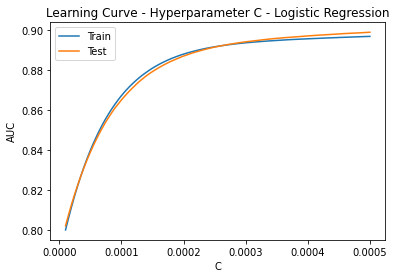

In [20]:
# learning curve
import numpy as np
param_values = [float(x) for x in np.linspace(0.00001, 0.0005, 100)]
draw_learning_curve(param_values)

## Decision Tree

In [22]:
# decision tree
from sklearn.tree import DecisionTreeClassifier # import decision tree dari sklearn
dt = DecisionTreeClassifier() # inisiasi object dengan nama dt
dt.fit(X_train, y_train) # fit model decision tree dari data train
eval_classification(dt)

Accuracy (Test Set): 0.86
Precision (Test Set): 0.58
Recall (Test Set): 0.56
F1-Score (Test Set): 0.57
roc_auc (test-proba): 0.74
roc_auc (train-proba): 1.00
roc_auc (crossval train): 1.0
roc_auc (crossval test): 0.7235021837672255


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
import numpy as np

# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
criterion = ['gini','entropy']
splitter = ['best','random']

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                      )

# Inisialisasi Model
dt = DecisionTreeClassifier(random_state=42)
model = GridSearchCV(dt, hyperparameters, cv=5, scoring='precision')
model.fit(X_train, y_train)

# Predict & Evaluation
y_pred = model.predict(X_test)#Check performa dari model
eval_classification(model)

show_feature_importance(model.best_estimator_)

## k-Nearest Neighbor

In [23]:
from sklearn.neighbors import KNeighborsClassifier # import knn dari sklearn
knn = KNeighborsClassifier() # inisiasi object dengan nama knn
knn.fit(X_train, y_train) # fit model KNN dari data train
eval_classification(knn)

Accuracy (Test Set): 0.88
Precision (Test Set): 0.66
Recall (Test Set): 0.55
F1-Score (Test Set): 0.60
roc_auc (test-proba): 0.87
roc_auc (train-proba): 0.96
roc_auc (crossval train): 0.9603527385820231
roc_auc (crossval test): 0.8464350934431533


In [24]:
from sklearn.model_selection import RandomizedSearchCV

n_neighbors = list(range(1,30))
p=[1,2]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, algorithm=algorithm)

knn.fit(X_train, y_train)
rs = RandomizedSearchCV(knn, hyperparameters, scoring='roc_auc', random_state=1, cv=5)
rs.fit(X_train, y_train)
eval_classification(rs)

Accuracy (Test Set): 0.87
Precision (Test Set): 0.69
Recall (Test Set): 0.42
F1-Score (Test Set): 0.52
roc_auc (test-proba): 0.91
roc_auc (train-proba): 0.93
roc_auc (crossval train): 0.9323675943571628
roc_auc (crossval test): 0.8909132321384096


# Oversampling Data

In [25]:
X_train_over_SMOTE, y_train_over_SMOTE = over_sampling.SMOTE(0.6,random_state=123).fit_resample(X_train, y_train)
print('Nilai unik target sebelum oversampling:\n', pd.Series(y).value_counts())
print('Nilai unik target sesudah oversampling:\n', pd.Series(y_train_over_SMOTE).value_counts())

Nilai unik target sebelum oversampling:
 False    10297
True      1908
Name: Revenue, dtype: int64
Nilai unik target sesudah oversampling:
 False    8268
True     4960
Name: Revenue, dtype: int64


In [26]:
X_train = X_train_over_SMOTE
y_train = y_train_over_SMOTE

## Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression # import logistic regression dari sklearn

logreg = LogisticRegression() # inisiasi object dengan nama logreg
logreg.fit(X_train, y_train) # fit model regression dari data train
eval_classification(logreg)

Accuracy (Test Set): 0.87
Precision (Test Set): 0.58
Recall (Test Set): 0.78
F1-Score (Test Set): 0.67
roc_auc (test-proba): 0.90
roc_auc (train-proba): 0.92
roc_auc (crossval train): 0.9028102780148334
roc_auc (crossval test): 0.881729462893464


In [30]:
from sklearn.model_selection import RandomizedSearchCV

penalty = ['l1', 'l2']
C = [float(x) for x in np.linspace(0.00001, 0.0005, 100)]
hyperparameters = dict(penalty=penalty, C=C)

logreg = LogisticRegression()
rs = RandomizedSearchCV(logreg, hyperparameters, scoring='roc_auc', random_state=1, cv=5, n_iter=50)
rs.fit(X_train, y_train)
eval_classification(rs)

Accuracy (Test Set): 0.87
Precision (Test Set): 0.59
Recall (Test Set): 0.76
F1-Score (Test Set): 0.67
roc_auc (test-proba): 0.90
roc_auc (train-proba): 0.91
roc_auc (crossval train): 0.897304312229474
roc_auc (crossval test): 0.8837809823707866


param value: 1e-05; train: 0.8247382543658411; test: 0.8152911425112568
param value: 1.9999999999999998e-05; train: 0.8455167464534856; test: 0.8344358740017321
param value: 2.9999999999999997e-05; train: 0.8600532611155328; test: 0.8482046730179388
param value: 3.9999999999999996e-05; train: 0.8703465898450302; test: 0.8583249197318494
param value: 4.9999999999999996e-05; train: 0.8778354313950404; test: 0.8658528999411446
param value: 5.9999999999999995e-05; train: 0.883306729598764; test: 0.8717695359041473
param value: 7e-05; train: 0.8873883667306522; test: 0.8762399096594525
param value: 7.999999999999999e-05; train: 0.8905044419214382; test: 0.8797150061965577
param value: 8.999999999999999e-05; train: 0.8928967053310862; test: 0.8824914946862723
param value: 9.999999999999999e-05; train: 0.8947696960297766; test: 0.8847894845133908
param value: 0.00010999999999999999; train: 0.8962745749254802; test: 0.8865383971251801
param value: 0.00011999999999999999; train: 0.8974762053857

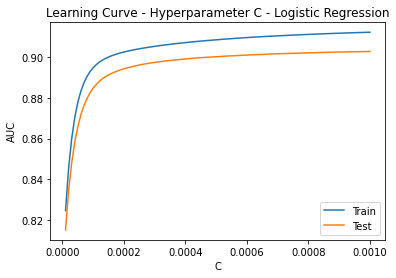

In [36]:
# learning curve
import numpy as np
param_values = [float(x) for x in np.linspace(0.00001, 0.001, 100)]
draw_learning_curve(param_values)

## Decision Tree

In [28]:
# decision tree
from sklearn.tree import DecisionTreeClassifier # import decision tree dari sklearn
dt = DecisionTreeClassifier() # inisiasi object dengan nama dt
dt.fit(X_train, y_train) # fit model decision tree dari data train
eval_classification(dt)

Accuracy (Test Set): 0.85
Precision (Test Set): 0.54
Recall (Test Set): 0.63
F1-Score (Test Set): 0.58
roc_auc (test-proba): 0.76
roc_auc (train-proba): 1.00
roc_auc (crossval train): 1.0
roc_auc (crossval test): 0.7203785335713556


## k-Nearest Neighbor

In [29]:
from sklearn.neighbors import KNeighborsClassifier # import knn dari sklearn
knn = KNeighborsClassifier() # inisiasi object dengan nama knn
knn.fit(X_train, y_train) # fit model KNN dari data train
eval_classification(knn)

Accuracy (Test Set): 0.85
Precision (Test Set): 0.54
Recall (Test Set): 0.78
F1-Score (Test Set): 0.64
roc_auc (test-proba): 0.87
roc_auc (train-proba): 0.99
roc_auc (crossval train): 0.9603527385820231
roc_auc (crossval test): 0.8464350934431533
